In [1]:
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy
import gensim
from gensim.utils import simple_preprocess

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('recipe_clean.csv')
df.head(1)

,link,title,ratings,num_reviews,ingredients,servings,cook_time,calorie,fat_g,carb_g,protein_g,cholesterol_mg,sodium_mg
0,https://www.allrecipes.com/recipe/100164/chip-...,Chip Truck Fries,4.44,44,"['6 baking potatoes, cut into 1/4 inch slices'...",4.0,60,369.0,14.0,56.3,6.5,0.0,478.0


In [3]:
df.shape

(5823, 13)

# Preprocess

In [4]:
# keep title and ingredients for text cleaning
df = df[['title', 'ingredients']]
df.head()

,title,ingredients
0,Chip Truck Fries,"['6 baking potatoes, cut into 1/4 inch slices'..."
1,Irish Bacon And Cabbage Soup,"['1/2 pound Irish bacon, diced', '2 large pota..."
2,Quick Salmon Salad,"['2 (6 ounce) cans pink salmon, drained', '1/2..."
3,Bills Seasoned Ketchup,"['1 (28 ounce) bottle ketchup', '2 teaspoons h..."
4,Celery Salad,"['3/4 cup sliced celery', '1/3 cup dried sweet..."


In [5]:
df.ingredients[0]

"['6 baking potatoes, cut into 1/4 inch slices', '1/4 cup vegetable oil', '2 teaspoons seasoned salt']"

In [6]:
# define a function to convert list to str
def list_to_str(x):
    """
    Convert list to str
    """
    # extract list from str
    x = ast.literal_eval(x)
    
    # convert list to str
    x = ','.join(x)

    return x

In [7]:
# apply function to df
df.ingredients = df.ingredients.apply(list_to_str)
df.head(1)

,title,ingredients
0,Chip Truck Fries,"6 baking potatoes, cut into 1/4 inch slices,1/..."


In [8]:
df.ingredients[0]

'6 baking potatoes, cut into 1/4 inch slices,1/4 cup vegetable oil,2 teaspoons seasoned salt'

### Remove number and punctuation

In [9]:
# create a list for text data
data = df.ingredients.values.tolist()

# remove number and punctuation
data = [re.sub(r'[^a-zA-Z]', ' ', sent.lower()) for sent in data] 
data[0]

'  baking potatoes  cut into     inch slices     cup vegetable oil   teaspoons seasoned salt'

In [10]:
# remove units
units = ['spoon','pound','cup','quart','ounce','pint','degree','dash','pinch','pack','halve','bunch','inch']
for unit in units:
    expre = re.compile('\w*' + unit + '\w*')
    data = [re.sub(expre, '', sent).strip() for sent in data]

data[0]

'baking potatoes  cut into      slices      vegetable oil    seasoned salt'

In [11]:
# remove duplicated whitespace
data = [' '.join(sent.split()) for sent in data]

data[0]

'baking potatoes cut into slices vegetable oil seasoned salt'

### Tokenize words

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(sentence))

data_words = list(sent_to_words(data))
data_words[0]

['baking',
 'potatoes',
 'cut',
 'into',
 'slices',
 'vegetable',
 'oil',
 'seasoned',
 'salt']

### Make bigram

In [13]:
# build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
data_bigram = [bigram_mod[doc] for doc in data_words]
data_bigram[0]

['baking',
 'potatoes',
 'cut',
 'into',
 'slices',
 'vegetable',
 'oil',
 'seasoned',
 'salt']

### Remove stopwords and lemmatize

In [15]:
stop_words = stopwords.words('english')

# remove stopwords
data_nonstop = [[word for word in doc if word not in stop_words] for doc in data_bigram]
data_nonstop[0]

['baking', 'potatoes', 'cut', 'slices', 'vegetable', 'oil', 'seasoned', 'salt']

In [16]:
# keep only noun and adj
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']): 
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# initialize spacy 'en' model, keeping only tagger component
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatize
data_lemmatized = lemmatization(data_nonstop, allowed_postags=['NOUN', 'ADJ'])
data_lemmatized[0]

['potato', 'slice', 'vegetable', 'oil', 'salt']

In [19]:
# check word frequencies
vocab = dict()
for doc in data_lemmatized:
    for word in doc:
        if word not in vocab.keys():
            vocab[word] = 1
        else:
            vocab[word] += 1

In [27]:
# self-define stopwords
recipe_stopwords = ['slice','large','diced','taste','leave','granule','sliced','fresh','plain','low','fat','whole',
                    'kernel','purpose','mix','ripe','medium','raw','coarse','style','active','dry','ground','piece',
                    'crushed','cut','minute','shredded','optional','cube','hour','bag','baby','seeded','small','clove',
                    'country','teardrop','leaf','center','fillet','sea','chunk','light','cent','head','heart',
                    'container','link','frozen','can','crumb','cooked','stalk','regular','dusting','heavy','round',
                    'rinsed','solid','creamy','z','warm','fluid','uncooked','short','shaving','sheet','soft','mixed',
                    'blend','flake','unbleached','sun','old','topping','wedge','thick','lean','extra','meal','hearty',
                    'preserve','mild','tough','half','crosswise','new','seasoning','unpeeled','key','boiling','hot',
                    'dog','amount','cold','cluster','snow','necessary','firm','food','spam','stale','cubed',
                    'temperature','granny_smith','seedless','boneless','strong','bottle','unsweetened','smoked',
                    'melted','thin','hard','pure','bulk','unsalted','deveined','cooking','box','softened','prepared',
                    'split','carton','canned','flavor','use','broken','free','lengthwise','real','dice','flaked',
                    'bite_sized','shoestring','reserved','direction','undrained','patted','original','sharp',
                    'reduced_fat','color','ball','toothpick','pressed','diagonal','good','season','bit','jumbo',
                    'complete','skim','chopped','paper','towel','roasted','flaky','less','flavoring','tube','fine',
                    'minced','square','unsliced','farm','process','size','single','refrigerated','skinless','coating',
                    'pitted','hulled','summer','at_room','bay','segmented','segment','rustic','seasoned','spiral',
                    'spray','peeler','divided','bite_size','silk','dinosaur','long','assorted','wish','restaurant',
                    'wash','solution','crumbled','least','grand','part','recipe','cool','miniature','mashed','razor',
                    'peeled','pasteurized','shore','lunch','ingredient','smart','top','rubbed','ready','shape','big',
                    'serving','mini','soak','mixture','rinse','full','parts_only','enough','rub','rich','oven','peel']

In [28]:
# remove self-defined stopwords
data_clean = [[word for word in doc if word not in recipe_stopwords] for doc in data_lemmatized]
data_clean[0]

['potato', 'vegetable', 'oil', 'salt']

In [55]:
# create a df with word counts
df_count = pd.DataFrame(vocab, index=['count']).transpose().sort_values('count', ascending=False)
df_count = df_count.reset_index().rename(columns={'index': 'ingredient'})
df_count.head()

,ingredient,count
0,salt,1795
1,garlic,1458
2,onion,1361
3,black pepper,1220
4,olive oil,1085


In [56]:
# plot the most common ingredients
def plot_ingredient(df, top_n=10, figsize=(8,10)):
    plt.figure(figsize=figsize)
    
    count = df['count'].iloc[:top_n]
    ingred = df['ingredient'].iloc[:top_n]
    sns.barplot(x=count, y=ingred, palette='Reds_r')
    plt.title(f'{top_n} most common ingredients\n')
    plt.xlabel('Count')
    plt.ylabel('Ingredient')
    plt.show()

In [ ]:
plot_ingredient(df_count, top_n=25)

# Topic Modeling

## LDA using gensim

In [29]:
import tqdm
from pprint import pprint

import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

### Create dictionary and corpus

In [30]:
# create Dictionary
id2word = corpora.Dictionary(data_clean)

# create corpus
texts = data_clean

# term doc frequency - mapping of (word_id, word_frequency)
corpus = [id2word.doc2bow(text) for text in texts]

In [31]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1)]

### Build LDA model

In [32]:
# Build LDA model using default settings
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100, 
                                       passes=10, 
                                       per_word_topics=True)

# chunksize - how many docs are processed at a time in the training algorithm
# passes - how often we train the model on the entire corpus

In [33]:
# print keywords in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.083*"pork" + 0.079*"pepper" + 0.053*"salt" + 0.053*"potato" + '
  '0.048*"italian" + 0.046*"black" + 0.037*"sausage" + 0.033*"garlic" + '
  '0.032*"onion" + 0.031*"oil"'),
 (1,
  '0.141*"olive" + 0.121*"oil" + 0.097*"pepper" + 0.067*"salt" + 0.058*"black" '
  '+ 0.054*"red" + 0.051*"onion" + 0.042*"bean" + 0.041*"tomato" + '
  '0.027*"garlic"'),
 (2,
  '0.150*"salmon" + 0.080*"rice" + 0.074*"mayonnaise" + 0.064*"onion" + '
  '0.050*"celery" + 0.044*"dill" + 0.041*"sweet" + 0.036*"lime" + '
  '0.034*"white" + 0.031*"egg"'),
 (3,
  '0.110*"pepper" + 0.084*"salt" + 0.082*"butter" + 0.080*"lemon" + '
  '0.054*"white" + 0.053*"juice" + 0.051*"black" + 0.043*"wine" + '
  '0.039*"mustard" + 0.038*"parsley"'),
 (4,
  '0.133*"sugar" + 0.091*"egg" + 0.090*"flour" + 0.081*"salt" + 0.059*"brown" '
  '+ 0.058*"water" + 0.055*"butter" + 0.050*"milk" + 0.048*"white" + '
  '0.041*"powder"'),
 (5,
  '0.179*"sauce" + 0.107*"soy" + 0.091*"oil" + 0.054*"ginger" + 0.048*"green" '
  '+ 0.044*"onio

In [52]:
# compute baseline Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_clean, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', np.round(coherence_lda, 3))

# compute Perplexity: the lower the better
perplexity = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', np.round(perplexity, 2)) 

Coherence Score:  0.435

Perplexity:  -4.89


In [41]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.204098  0.068363       1        1  17.456926
7      0.140250  0.057471       2        1  16.745832
6      0.013911 -0.235088       3        1  13.310946
8      0.018785 -0.067408       4        1  10.593098
4     -0.259764 -0.136535       5        1   9.117343
5     -0.057613  0.320459       6        1   8.052632
3      0.156190 -0.030896       7        1   7.741186
9     -0.166029  0.123093       8        1   6.682034
0      0.130336 -0.087398       9        1   6.675255
2     -0.180162 -0.012062      10        1   3.624746, topic_info=     Category         Freq        Term        Total  loglift  logprob
21    Default  1676.000000       sauce  1676.000000  30.0000  30.0000
36    Default  1602.000000       olive  1602.000000  29.0000  29.0000
33    Default  1225.000000      cheese  1225.000000  28.0000  28.0000
10    Default  4278.000000      pepper  4278.000000  27.0000  27.0000
37    Default   988.000000       sugar   988.000000  26.0000  26.0000
78    Default   840.000000       cream   840.000000  25.0000  25.0000
102   Default   691.000000     chicken   691.000000  24.0000  24.0000
0     Default  2814.000000         oil  2814.000000  23.0000  23.0000
55    Default   961.000000         egg   961.000000  22.0000  22.0000
218   Default   549.000000         soy   549.000000  21.0000  21.0000
32    Default  1325.000000      butter  1325.000000  20.0000  20.0000
18    Default   347.000000      salmon   347.000000  19.0000  19.0000
35    Default   946.000000       flour   946.000000  18.0000  18.0000
16    Default   509.000000       lemon   509.000000  17.0000  17.0000
120   Default   443.000000       broth   443.000000  16.0000  16.0000
117   Default   449.000000        rice   449.000000  15.0000  15.0000
13    Default  1085.000000      tomato  1085.000000  14.0000  14.0000
182   Default   353.000000        pork   353.000000  13.0000  13.0000
49    Default  1475.000000       water  1475.000000  12.0000  12.0000
56    Default   734.000000        milk   734.000000  11.0000  11.0000
4     Default  2237.000000       black  2237.000000  10.0000  10.0000
52    Default   686.000000    mushroom   686.000000   9.0000   9.0000
82    Default   443.000000      carrot   443.000000   8.0000   8.0000
17    Default  3369.000000       onion  3369.000000   7.0000   7.0000
57    Default  1015.000000       white  1015.000000   6.0000   6.0000
3     Default  1012.000000   vegetable  1012.000000   5.0000   5.0000
30    Default   756.000000        bean   756.000000   4.0000   4.0000
31    Default   341.000000       brown   341.000000   3.0000   3.0000
14    Default   474.000000      celery   474.000000   2.0000   2.0000
205   Default   393.000000      ginger   393.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
555   Topic10     5.733096   untreated     6.670749   3.1659  -6.0007
812   Topic10     5.499989     jasmine     6.437736   3.1600  -6.0422
65    Topic10    60.090321     lettuce    71.070526   3.1496  -3.6511
388   Topic10     4.907837    oriental     5.845488   3.1425  -6.1561
548   Topic10     4.801136     trimmed     5.738828   3.1390  -6.1781
558   Topic10     4.797548       filet     5.735290   3.1389  -6.1789
1112  Topic10     4.775835      pigeon     5.714863   3.1379  -6.1834
554   Topic10     4.530197       cedar     5.467848   3.1293  -6.2362
717   Topic10     4.448579   available     5.386280   3.1261  -6.2544
833   Topic10     4.349789     gelatin     5.287434   3.1222  -6.2768
937   Topic10     3.715061  unflavored     4.652795   3.0923  -6.4346
496   Topic10     3.581438      relish     4.519101   3.0848  -6.4712
117   Topic10   184.945633        rice   449.592712   2.4291  -2.5269
252   Topic10    13.859797       grain    23.203737   2.8021  -5.1180
45    Topic10    42.558250    cucumber    92.843811   2.5373  -3.9961
74    Topic10    82

### Tune hyperparameters 

In [42]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_clean, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [43]:
grid = {}
grid['Validation_Set'] = {}

# topics range
topics_range = range(2, 11, 1)

# alpha parameter
alpha = [0.01, 0.1, 1, 'symmetric', 'asymmetric']

# beta parameter
beta = [0.01, 0.1, 1, 'symmetric']

# validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus[:int(num_of_docs*0.75)], corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

In [44]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 67%|██████▋   | 360/540 [58:01<40:06, 13.37s/it]  


In [46]:
df_result = pd.read_csv('lda_tuning_results.csv')
df_result.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.389295
1,75% Corpus,2,0.01,0.1,0.389295
2,75% Corpus,2,0.01,1,0.401169
3,75% Corpus,2,0.01,symmetric,0.378138
4,75% Corpus,2,0.1,0.01,0.389295


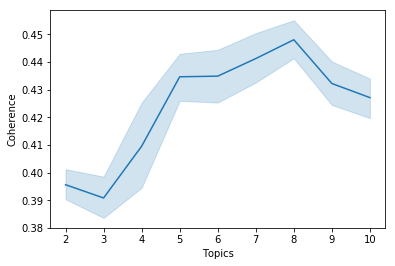

In [47]:
# visualize c_v score vs topics in 75% corpus
df_result_75 = df_result[df_result.Validation_Set == '75% Corpus']
sns.lineplot(data=df_result_75, x='Topics', y='Coherence');

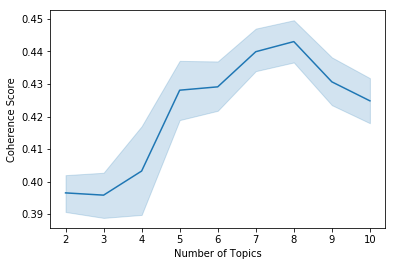

In [49]:
# visualize c_v score vs # topics in 100% corpus
df_result_100 = df_result[df_result.Validation_Set == '100% Corpus']
sns.lineplot(data=df_result_100, x='Topics', y='Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score');

#### The best number of topics is 8.

In [51]:
# look for the best alpha and beta based on c_v score
df_result_100[df_result_100.Topics == 8].sort_values('Coherence', ascending=False)[:5]

,Validation_Set,Topics,Alpha,Beta,Coherence
310,100% Corpus,8,1,1,0.465253
302,100% Corpus,8,0.01,1,0.463119
318,100% Corpus,8,asymmetric,1,0.462247
307,100% Corpus,8,0.1,symmetric,0.458820
309,100% Corpus,8,1,0.1,0.453624


#### With alpha of 1 and beta of 1, I can achieve 6.9% improvement in coherence score over the baseline.

In [53]:
# build the final model
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=8, 
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha=1,
                                             eta=1)

In [54]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.080213  0.219038       1        1  15.019412
1     -0.203096 -0.037886       2        1  14.281673
3     -0.076202 -0.067420       3        1  14.202337
4      0.262488  0.116143       4        1  12.375782
0      0.010199 -0.013532       5        1  11.871536
6      0.130797 -0.233937       6        1  11.348742
5     -0.098767 -0.026202       7        1  11.003708
2      0.054795  0.043796       8        1   9.896814, topic_info=    Category         Freq         Term        Total  loglift  logprob
10   Default  3590.000000       pepper  3590.000000  30.0000  30.0000
4    Default  1932.000000        black  1932.000000  29.0000  29.0000
21   Default  1443.000000        sauce  1443.000000  28.0000  28.0000
36   Default  1426.000000        olive  1426.000000  27.0000  27.0000
33   Default  1164.000000       cheese  1164.000000  26.0000  26.0000
0    Default  2454.000000          oil  2454.000000  25.0000  25.0000
78   Default   791.000000        cream   791.000000  24.0000  24.0000
35   Default   835.000000        flour   835.000000  23.0000  23.0000
32   Default  1168.000000       butter  1168.000000  22.0000  22.0000
53   Default   823.000000          red   823.000000  21.0000  21.0000
37   Default   835.000000        sugar   835.000000  20.0000  20.0000
55   Default   798.000000          egg   798.000000  19.0000  19.0000
2    Default  2883.000000         salt  2883.000000  18.0000  18.0000
52   Default   650.000000     mushroom   650.000000  17.0000  17.0000
102  Default   644.000000      chicken   644.000000  16.0000  16.0000
13   Default   904.000000       tomato   904.000000  15.0000  15.0000
20   Default   607.000000       powder   607.000000  14.0000  14.0000
56   Default   651.000000         milk   651.000000  13.0000  13.0000
1    Default   625.000000       potato   625.000000  12.0000  12.0000
16   Default   520.000000        lemon   520.000000  11.0000  11.0000
30   Default   590.000000         bean   590.000000  10.0000  10.0000
9    Default   475.000000        juice   475.000000   9.0000   9.0000
17   Default  2966.000000        onion  2966.000000   8.0000   8.0000
218  Default   464.000000          soy   464.000000   7.0000   7.0000
14   Default   425.000000       celery   425.000000   6.0000   6.0000
75   Default   453.000000         beef   453.000000   5.0000   5.0000
57   Default   888.000000        white   888.000000   4.0000   4.0000
120  Default   404.000000        broth   404.000000   3.0000   3.0000
64   Default   505.000000        bread   505.000000   2.0000   2.0000
24   Default   427.000000      parsley   427.000000   1.0000   1.0000
..       ...          ...          ...          ...      ...      ...
531   Topic8    95.746040         chop   104.268105   2.2277  -4.1897
15    Topic8   101.665558         dill   110.923416   2.2258  -4.1297
20    Topic8   553.644043       powder   607.868164   2.2195  -2.4349
133   Topic8    72.079575        roast    80.135452   2.2070  -4.4736
123   Topic8    96.601143        apple   110.380989   2.1796  -4.1808
202   Topic8    44.560989         loin    52.197395   2.1548  -4.9545
219   Topic8    44.887112         bone    53.626820   2.1351  -4.9472
204   Topic8    59.411633    cranberry    71.961563   2.1213  -4.6669
268   Topic8    45.172264        ranch    54.886101   2.1182  -4.9409
440   Topic8    48.870693         skin    59.475094   2.1166  -4.8622
289   Topic8    30.573496   tenderloin    38.235519   2.0893  -5.3313
461   Topic8    34.104286        panko    42.904259   2.0834  -5.2220
275   Topic8    34.027512        cider    43.892826   2.0584  -5.2242
64    Topic8   385.898987        bread   505.324524   2.0433  -2.7958
301   Topic8    34.340878         ring    45.135056   2.0396  -5.2151
347   Topic8    28.451229  horseradish    37.720837   2.0309  -5.4032
189   Topic8    21.925055       pickle    29.445837   2.0

In [55]:
pyLDAvis.save_html(LDAvis_prepared, 'recipe_lda.html')

In [56]:
# print keywords in the 8 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0,
  '0.131*"onion" + 0.084*"chicken" + 0.077*"potato" + 0.056*"beef" + '
  '0.055*"celery" + 0.052*"broth" + 0.048*"carrot" + 0.038*"thyme" + '
  '0.031*"salt" + 0.022*"water"'),
 (1,
  '0.155*"oil" + 0.155*"olive" + 0.088*"red" + 0.088*"tomato" + 0.064*"bean" + '
  '0.037*"wine" + 0.033*"onion" + 0.026*"vinegar" + 0.023*"basil" + '
  '0.019*"salt"'),
 (2,
  '0.088*"powder" + 0.061*"bread" + 0.053*"pork" + 0.047*"salmon" + '
  '0.037*"salt" + 0.037*"mustard" + 0.033*"onion" + 0.032*"garlic" + '
  '0.023*"mayonnaise" + 0.020*"honey"'),
 (3,
  '0.158*"sauce" + 0.063*"oil" + 0.062*"vegetable" + 0.062*"green" + '
  '0.054*"water" + 0.050*"soy" + 0.044*"onion" + 0.043*"rice" + 0.038*"white" '
  '+ 0.020*"ginger"'),
 (4,
  '0.113*"butter" + 0.104*"flour" + 0.095*"sugar" + 0.094*"egg" + 0.078*"milk" '
  '+ 0.067*"salt" + 0.056*"white" + 0.051*"water" + 0.037*"brown" + '
  '0.014*"soda"'),
 (5,
  '0.073*"lemon" + 0.066*"juice" + 0.056*"garlic" + 0.055*"parsley" + '
  '0.049*"shrimp" + 0.049

In [57]:
doc_lda[0]

[(0, 0.1874151),
 (1, 0.13302745),
 (2, 0.09080067),
 (3, 0.1676477),
 (4, 0.096621),
 (5, 0.10781006),
 (6, 0.08579235),
 (7, 0.1308857)]

In [79]:
# create a df to show lda matrix
lda_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}

for _ in range(len(doc_lda)):
    for key in list(lda_dict.keys()):
        lda_dict[key].append(0)

# create a df filled with 0
lda_matrix = pd.DataFrame(lda_dict)

# fill the probability distribution of topics for each row
for i, row in enumerate(doc_lda):
    for j, (topic, prop_topic) in enumerate(row):
        lda_matrix.loc[i, topic] = prop_topic

In [80]:
lda_matrix.head()

,0,1,2,3,4,5,6,7
0,0.187419,0.133036,0.090798,0.167690,0.096604,0.107746,0.085791,0.130915
1,0.189180,0.107546,0.058631,0.198974,0.056827,0.128793,0.058054,0.201996
2,0.162212,0.069880,0.210755,0.096428,0.068746,0.228209,0.075688,0.088082
3,0.088998,0.075463,0.150191,0.154774,0.073123,0.075433,0.078716,0.303301
4,0.188432,0.101387,0.172610,0.071278,0.057590,0.169700,0.056743,0.182260


In [81]:
lda_matrix.shape

(5823, 8)

In [82]:
# add recipe name
lda_matrix = lda_matrix.merge(df, left_index=True, right_index=True, how='inner')
lda_matrix.head()

,0,1,2,3,4,5,6,7,title,ingredients
0,0.187419,0.133036,0.090798,0.167690,0.096604,0.107746,0.085791,0.130915,Chip Truck Fries,"6 baking potatoes, cut into 1/4 inch slices,1/..."
1,0.189180,0.107546,0.058631,0.198974,0.056827,0.128793,0.058054,0.201996,Irish Bacon And Cabbage Soup,"1/2 pound Irish bacon, diced,2 large potatoes,..."
2,0.162212,0.069880,0.210755,0.096428,0.068746,0.228209,0.075688,0.088082,Quick Salmon Salad,"2 (6 ounce) cans pink salmon, drained,1/2 cup ..."
3,0.088998,0.075463,0.150191,0.154774,0.073123,0.075433,0.078716,0.303301,Bills Seasoned Ketchup,"1 (28 ounce) bottle ketchup,2 teaspoons hot pe..."
4,0.188432,0.101387,0.172610,0.071278,0.057590,0.169700,0.056743,0.182260,Celery Salad,"3/4 cup sliced celery,1/3 cup dried sweet cher..."


In [87]:
# assign topic names using my judgement
lda_matrix.sort_values(by=0, ascending=False)[:5]
# topic 0 looks like beef and poultry

,0,1,2,3,4,5,6,7,title,ingredients
3510,0.532130,0.052448,0.053499,0.051541,0.083257,0.054423,0.055383,0.117320,Maple Roast Turkey,"2 cups apple cider,1/3 cup real maple syrup,2 ..."
3882,0.529061,0.052702,0.122309,0.059803,0.057603,0.066760,0.057193,0.054569,Slow Cooker Split Pea Sausage Soup,"1 pound dried split peas,10 cups water,1 pound..."
1183,0.507830,0.051255,0.055820,0.049761,0.052756,0.115927,0.050456,0.116195,Juicy Thanksgiving Turkey,"2 tablespoons dried parsley,2 tablespoons grou..."
4949,0.485782,0.068971,0.072402,0.082555,0.077893,0.071035,0.071038,0.070324,Hamburger Hash,"1 pound ground beef,1 large onion, chopped,1 p..."
1081,0.479072,0.047632,0.047919,0.046549,0.130568,0.047416,0.048928,0.151916,Maple Roast Turkey And Gravy,"2 cups apple cider,1/3 cup real maple syrup,2 ..."


In [88]:
lda_matrix.sort_values(by=1, ascending=False)[:5]
# topic 1 looks like veggies

,0,1,2,3,4,5,6,7,title,ingredients
315,0.084133,0.546794,0.039254,0.047335,0.036461,0.123429,0.084969,0.037626,Heirloom Tomato Salad With Pearl Couscous,"2 cups vegetable stock,1 tablespoon extra-virg..."
614,0.045072,0.525886,0.050778,0.046191,0.078758,0.054028,0.058162,0.141125,Caprese Salad With Grilled Flank Steak,"2 tomatoes, diced,1 (4 ounce) ball fresh mozza..."
110,0.080957,0.524907,0.046570,0.058725,0.046208,0.049097,0.047141,0.146394,Marinated Green Beans With Olives Tomatoes And...,"2 pounds fresh green beans, trimmed,1/4 cup ol..."
586,0.042257,0.518296,0.083451,0.052999,0.043014,0.044680,0.130144,0.085159,Roasted Beet Avocado And Pistachio Salad,"3 large beets,extra-virgin olive oil,balsamic ..."
1956,0.047210,0.513626,0.082097,0.055234,0.043960,0.094901,0.067122,0.095850,Panzanella Salad,"6 cups day old Italian bread, torn into bite-s..."


In [89]:
lda_matrix.sort_values(by=2, ascending=False)[:5]
# topic 2 looks like pork and fish 

,0,1,2,3,4,5,6,7,title,ingredients
1630,0.045749,0.042369,0.499329,0.044733,0.201210,0.044915,0.041241,0.080454,Home Cured Holiday Ham,"1 (7 pound) fresh, bone-in pork shoulder (""pic..."
3832,0.081485,0.069730,0.496348,0.070825,0.066916,0.070145,0.074708,0.069843,Slow Cooker Cranberry Pork,"1 (16 ounce) can cranberry sauce,1/3 cup Frenc..."
966,0.073768,0.068785,0.474516,0.081027,0.079935,0.070126,0.067180,0.084664,Tuna Noodles Pickles And Cheese,"8 ounces uncooked elbow macaroni,2 dill pickle..."
576,0.054885,0.096109,0.463994,0.049086,0.095396,0.099313,0.082751,0.058468,Bacon Dijon Egg Salad Sandwich,"10 hard-cooked eggs, chopped,6 slices crispy c..."
219,0.071735,0.088846,0.456273,0.125426,0.058223,0.074170,0.063645,0.061682,Campbellsr Slow Cooked Pulled Pork Sandwiches,"1 tablespoon vegetable oil,3 1/2 pounds bonele..."


In [91]:
lda_matrix.sort_values(by=3, ascending=False)[:5]
# topic 3 looks like Asian cuisine

,0,1,2,3,4,5,6,7,title,ingredients
846,0.042767,0.053751,0.046664,0.639508,0.083326,0.051047,0.043478,0.039458,Carries Pad Thai Salad,"1 (12 ounce) package dried rice noodles,1/2 cu..."
1428,0.037041,0.044283,0.085614,0.631530,0.068364,0.050794,0.043226,0.039149,Chinese Pork Dumplings,"1/2 cup soy sauce,1 tablespoon seasoned rice v..."
2878,0.042741,0.038974,0.038473,0.630801,0.047755,0.049652,0.036568,0.115037,Stir Fried Tofu With Cashews,"1/2 (12 ounce) package extra-firm tofu, sliced..."
2635,0.040751,0.071182,0.041388,0.630380,0.045559,0.037396,0.068705,0.064639,Fun Karnal Beef And Broccoli,"2 1 1/2-inch-thick New York strip steaks, cut ..."
2849,0.034055,0.037854,0.069805,0.630118,0.067695,0.038892,0.031843,0.089737,Perfect Pot Stickers,"Filling:,1 pound ground pork,4 cloves minced g..."


In [92]:
lda_matrix.sort_values(by=4, ascending=False)[:5]
# topic 4 looks like baking goods

,0,1,2,3,4,5,6,7,title,ingredients
3175,0.040815,0.039333,0.040371,0.042981,0.714999,0.040060,0.039569,0.041872,Mardi Gras King Cake,"PASTRY:,1 cup milk,1/4 cup butter,2 (.25 ounce..."
3314,0.043379,0.042447,0.066986,0.045014,0.671274,0.042877,0.042562,0.045460,Oatmeal Whoopie Pies,"2 cups packed brown sugar,3/4 cup butter,2 egg..."
3309,0.047429,0.046463,0.047628,0.045836,0.663767,0.046909,0.046830,0.055138,Chocolate Revel Bars,"3 cups quick cooking oats,2 1/2 cups all-purpo..."
5028,0.048834,0.046870,0.050639,0.055141,0.657521,0.047995,0.046943,0.046057,Crisp Peach Cobbler,"6 large fresh peaches, pitted and cut into eig..."
5061,0.048841,0.048294,0.049005,0.048031,0.656285,0.048555,0.048605,0.052384,Peanut Butter Cookies Ix,"1/2 cup butter, softened,3/4 cup brown sugar,3..."


In [93]:
lda_matrix.sort_values(by=5, ascending=False)[:5]
# topic 5 looks like curry-based dishes

,0,1,2,3,4,5,6,7,title,ingredients
2871,0.042088,0.069717,0.043449,0.086983,0.042515,0.522397,0.040748,0.152103,Real Thai Green Curry Paste Nam Prik Gen Kayo Wan,"1 cup chopped Thai chile peppers,3 shallots, c..."
3197,0.050420,0.051246,0.045662,0.061704,0.043830,0.503149,0.044361,0.199628,Cod Curry,"2 tablespoons vegetable oil,1 medium onion, ch..."
2425,0.129562,0.096879,0.044618,0.055243,0.107451,0.476043,0.041025,0.049179,Chicken Curry V,"2 tablespoons olive oil,1 (2 inch) piece cinna..."
2431,0.053034,0.057514,0.052577,0.146749,0.058745,0.471605,0.048527,0.111250,Moong Dal,2 1/2 cups moong dal (split husked mung beans)...
1184,0.072370,0.129449,0.061144,0.100388,0.056489,0.458681,0.060155,0.061324,Red Lentil Curry,"2 cups red lentils,1 large onion, diced,1 tabl..."


In [94]:
lda_matrix.sort_values(by=6, ascending=False)[:5]
# topic 6 looks like cheese-based dishes

,0,1,2,3,4,5,6,7,title,ingredients
3509,0.046354,0.047695,0.083317,0.055464,0.045671,0.047006,0.585001,0.089493,Southwestern Turkey Casserole,1 (10.75 ounce) can condensed cream of chicken...
2684,0.076132,0.042717,0.041859,0.046522,0.064121,0.042837,0.561587,0.124225,Crawfish Chowder,"1/4 cup butter,1/2 bunch green onions, chopped..."
3061,0.063108,0.061713,0.057392,0.067059,0.072447,0.059574,0.561065,0.057642,Spinach Enchiladas,"1 tablespoon butter,1/2 cup sliced green onion..."
1467,0.065634,0.062966,0.060543,0.071718,0.058947,0.062355,0.556819,0.061018,Taco Lasagna,"2 pounds lean ground beef,2 (1.25 ounce) packa..."
3777,0.058911,0.053045,0.053608,0.052743,0.125241,0.053461,0.550668,0.052324,Simply Potatoesr Cheesy Hash Browns,"Hash Browns:,1 (20 ounce) package Simply Potat..."


In [95]:
lda_matrix.sort_values(by=7, ascending=False)[:5]
# topic 7 looks like pepper-seasoned dishes

,0,1,2,3,4,5,6,7,title,ingredients
1793,0.158668,0.059012,0.090699,0.067204,0.040735,0.049294,0.041980,0.492409,Chile Verde Ii,"6 pounds cubed pork stew meat,1/4 cup vegetabl..."
1487,0.130207,0.064775,0.065787,0.063099,0.067138,0.064416,0.063928,0.480651,Beerbecue Beef Flank Steak,"1/2 cup ketchup,1/4 cup molasses,1/3 cup white..."
1385,0.175343,0.069582,0.049222,0.078423,0.049497,0.056790,0.047781,0.473362,Chef Johns Braised Lamb Shanks,"4 lamb shanks,salt and ground black pepper to ..."
5793,0.058206,0.070298,0.052690,0.085889,0.098268,0.068574,0.095222,0.470854,Venison Fajitas,"Fajita Seasoning:,2 teaspoons seasoned salt,1/..."
2728,0.038090,0.037531,0.049599,0.193421,0.065919,0.126299,0.036767,0.452373,Key West Shrimp Boil With Key Lime Mustard Sauce,"Key Lime Mustard Sauce:,1 cup mayonnaise,1/2 c..."


In [96]:
# drop ingredients columns 
lda_matrix.drop('ingredients', axis=1, inplace=True)

# change column name
lda_matrix.columns = ['beef_poultry','veggies','pork_fish','asian','baking','curry_based','cheese_based','pepper_based','title']
lda_matrix.head()

,beef_poultry,veggies,pork_fish,asian,baking,curry_based,cheese_based,pepper_based,title
0,0.187419,0.133036,0.090798,0.167690,0.096604,0.107746,0.085791,0.130915,Chip Truck Fries
1,0.189180,0.107546,0.058631,0.198974,0.056827,0.128793,0.058054,0.201996,Irish Bacon And Cabbage Soup
2,0.162212,0.069880,0.210755,0.096428,0.068746,0.228209,0.075688,0.088082,Quick Salmon Salad
3,0.088998,0.075463,0.150191,0.154774,0.073123,0.075433,0.078716,0.303301,Bills Seasoned Ketchup
4,0.188432,0.101387,0.172610,0.071278,0.057590,0.169700,0.056743,0.182260,Celery Salad


In [97]:
# save lda_matrix
lda_matrix.to_csv('recipe_ida.csv', index=False)

In [98]:
lda_matrix.shape

(5823, 9)

In [ ]:
import pandas as pd

In [1]:
df = pd.read_csv('recipe_ida.csv')
df = df[['title','beef_poultry','veggies','pork_fish','asian','baking','curry_based','cheese_based','pepper_based']]
df.head(8)

NameError: name 'pd' is not defined

References:

http://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/